# Exercise – Coffee Beans & Cloves Image Processing

We will work on the image **`coffeebeans.jpeg`** (plate with coffee beans and cloves).  
The goal is to handle shadows, create masks, count only coffee beans, and extract positions/sizes.  

---

### Part (a) – Shadow Removal (5p)
- Apply image processing techniques to eliminate shadows.  
- Describe the methods and explain how they work.  
- Show intermediate and final results.  

---

### Part (b) – Masking (5p)
- Create a mask for coffee beans and cloves.  
- Generate two images:  
  1. With shadows included  
  2. Without shadows  

---

### Part (c) – Coffee Bean Selection (5p)
- Make a selection so that **only coffee beans** are counted (exclude cloves).  

---

### Part (d) – Position Extraction (5p)
- Create a list of **center (x, y) positions** of all coffee beans.  

---

### Part (e) – Size Estimation (5p)
- Compute the **size of coffee beans**.  
- Explain how this can be done and/or why it is challenging.  


## Table of contents

- <a href='#E2'>Exercise 2 </a>
    - <a href='#E2a'>Exercise 2 (a): Shadow removing techniques</a>
    - <a href='#E2b'>Exercise 2 (b): Masking of objects with and without shadow</a>
    - <a href='#E2c'>Exercise 2 (c): Counting the coffee beans</a>
    - <a href='#E2d'>Exercise 2 (d): List with the center x,y positions of all the coffee beans</a>
    - <a href='#E2e'>Exercise 2 (e): Computing the size of the coffee beans is challenging</a>


--------------------------------------------------------------------------------------------
## Solution starts here
--------------------------------------------------------------------------------------------

<a id='E2'></a>
# <font color='blue '>Exercise 2<font>


At first, I imported the necessary modules and images for this task. After importing the image, I cropped the image for getting rid of the background without any objects present in it.
    
### Importing the necessary modules and the image for this task


In [ ]:
# Importing the necessary modules
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

# For morphology
from skimage.morphology import erosion, dilation, opening, square, disk, remove_small_holes

# For conversion of images
from skimage.color import rgb2lab, gray2rgb

# For binarising
from skimage.filters import try_all_threshold, threshold_otsu, threshold_li

# For watershed
from scipy import ndimage as ndi#for distance
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import measure # measure objects

# For ignoring futurewarnings about indices
import warnings
warnings.simplefilter(action ='ignore', category=FutureWarning)

In [ ]:
# Function for getting the image as RGB and gray
def get_image(filename):
    """ This function returns the image in 2 formats: RGB & gray"""

    image_gray = io.imread(filename, as_gray = True)
    image_RGB = io.imread(filename, as_gray = False)

    return image_gray, image_RGB

# Displaying the original in gray and RGB format
def display_RGB_n_gray_images(image_RGB, image_gray, size =(8, 6)):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = size)

    ax[0].imshow(image_RGB)
    ax[0].set_title('Original RGB image', fontsize = 11)

    ax[1].imshow(image_gray, cmap='gray')
    ax[1].set_title('Original Gray image', fontsize = 11)

    for row in ax:
        row.axis('off')

    fig.tight_layout()
    plt.show()

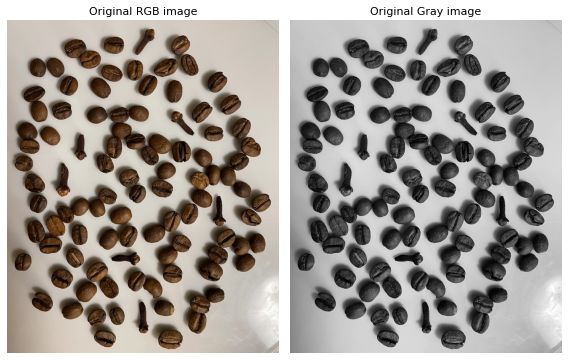

In [ ]:
# Getting the image [Reusing the function from Exercise 2(a)]
image_gray, image_RGB = get_image("coffeebeans.jpg")

# Cropping for getting the image without any white background
image_gray = image_gray[330:3670, 130:2860]
image_RGB = image_RGB[330:3670, 130:2860]

# Displaying the images [Reusing the function from Exercise 2(a)]
display_RGB_n_gray_images(image_RGB, image_gray, size=(8,6))

<center>Figure- 5: Displaying the image in RGB and gray-scale </center>

<a id='E2a'></a>
## <font color='blue '>Exercise 2 (a): Shadow removing techniques<font>

From the given image, we can see both the RGB and the gray version of the images have shadows in them. So, for removing the shadows a modified masking process has been followed. The code has been presented in Exercise 2(b) and the steps have been described below:
- **Step 1: Choosing the color channel:** Finding the appropritate color channel which has the minimum amount of shadow present in it. For this we have checked the RGB and CIE Lab colour space.
   - RGB has 3 color channels: red, green and blue.
   - CIE Lab has 3 color channels: L, A and B.
   
From this, step I have identified **image-A** from the CIE Lab has the most appropriate image with minimum shadows present.
- **Step 2: Creating a mask:** Using the chosen "image-A" a mask has been created by the following steps.
     - **1. Binarising/thresholding**: Analyzed all the binarising methods on the chosen "image-A". Found the "Li" is the most suitable among the binarising/thresholding methods because it eliminates most of the shadow parts and creates minimum holes in the objects.
     - **2. Filling holes**:
         - With the inverted binary image, I used remove_small_holes() with area_threshold = 500 from the morphology which filled up most of the holes present in the objects.
         - Then for further minimizing the holes, I tried to use closing() with disk(3) and disk(5) which did not work well. So, instead of that I have used dilation() with disk(3) and erosion() with disk(1) for 4 times, which gave the same result as closing(), but with better filling holes result.
         - Then finally, remove_small_holes()  with area_threshold = 500 were applied. Then inverted the image to get the final mask of the "image-A".
- **Step 3: Generating the image without shadows (Masked image):**
     - For masking, I have created a custom function called masking_image() which takes the original RGB image and the mask, then returns the masked image.
     - For matching the dimensions of the RGB image, I converted the mask from gray to the RGB format using the gray2rgb() which made it easier to do the "OR operation" between the pixel of both the images.

Thus, we get our masked image which is without any shadows. **<font color='blue '>[The code and the result images have been presented in the Exercise 2 (b)]<font>**


<a id='E2b'></a>
## <font color='blue '>Exercise 2 (b): Masking of objects with and without shadow<font>

### Masking without shadow

**Step 1: Displaying and choosing the color channel:** After analyzing the color channels from the RGB and CIE Lab colour space, I have found the "image-A" is the most suitable one with the minimum amount of shadow.

In [ ]:
# Splitting the RGB color channels
img_red = image_RGB [:,:,0] # pull out the red channel
img_green = image_RGB [:,:,1] # pull out the green channel
img_blue = image_RGB [:,:,2] # pull out the blue channel

# Splitting the CIE LAB Stack
img_lab = rgb2lab(image_RGB)# Converting from RGB to LAB stack
img_l = img_lab[:,:,0] # pull out L channel
img_a = img_lab[:,:,1] # pull out A channel
img_b = img_lab[:,:,2] # pull out B channel

# Displaying differnt color channels of the original RGB image
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 10))
fig.suptitle("Choosing color channel for the Mask", fontsize = 14)
ax[0,0].imshow(img_l, cmap='gray')
ax[0,0].set_title('Image L from LAB stack', fontsize = 12)

ax[0,1].imshow(img_a, cmap='gray')
ax[0,1].set_title('Image A from LAB stack', fontsize = 12)

ax[0,2].imshow(img_b, cmap='gray')
ax[0,2].set_title('Image B from LAB stack', fontsize = 12)

ax[1,0].imshow(img_red, cmap='gray')
ax[1,0].set_title('Image Red from RGB', fontsize = 12)

ax[1,1].imshow(img_green, cmap='gray')
ax[1,1].set_title('Image Green from RGB', fontsize = 12)

ax[1,2].imshow(img_blue, cmap='gray')
ax[1,2].set_title('Image Blue from RGB', fontsize = 12)

for row in ax:
    for col in row:
        col.axis('off')

fig.tight_layout()
plt.show()

<center>Figure- 6: Choosing color channel for the Mask </center>

**Step 2: Mask creation:**
- After analysing all the thresholding methods, chosen Li for binarising the image.
- After binarisation, on the inverted binary image performed fill holes using remove_small_holes(), dilation() and erosion().
- Then inverted the image for obtainng the final mask.


In [ ]:
# Creating mask without shadows

# Binarising the image using the Li filter
thresh = threshold_li(img_a)
binary_li = img_a > thresh

# Filling the holes of the objects in the binary image

# Step1: using remove_small_holes
inverted_binary_li = np.invert(binary_li)
holes_filled_without_shadow = remove_small_holes(inverted_binary_li, area_threshold = 500)

# Step2: using dilation & erosion
mask_without_shadow = np.invert(holes_filled_without_shadow.copy())
for _ in range(4):
    mask_without_shadow = dilation(mask_without_shadow, disk(3))
for _ in range(4):
    mask_without_shadow = erosion(mask_without_shadow, disk(1))

mask_without_shadow = remove_small_holes(mask_without_shadow, area_threshold = 800)
mask_without_shadow = np.invert(mask_without_shadow)*1.0 # for making it numerical

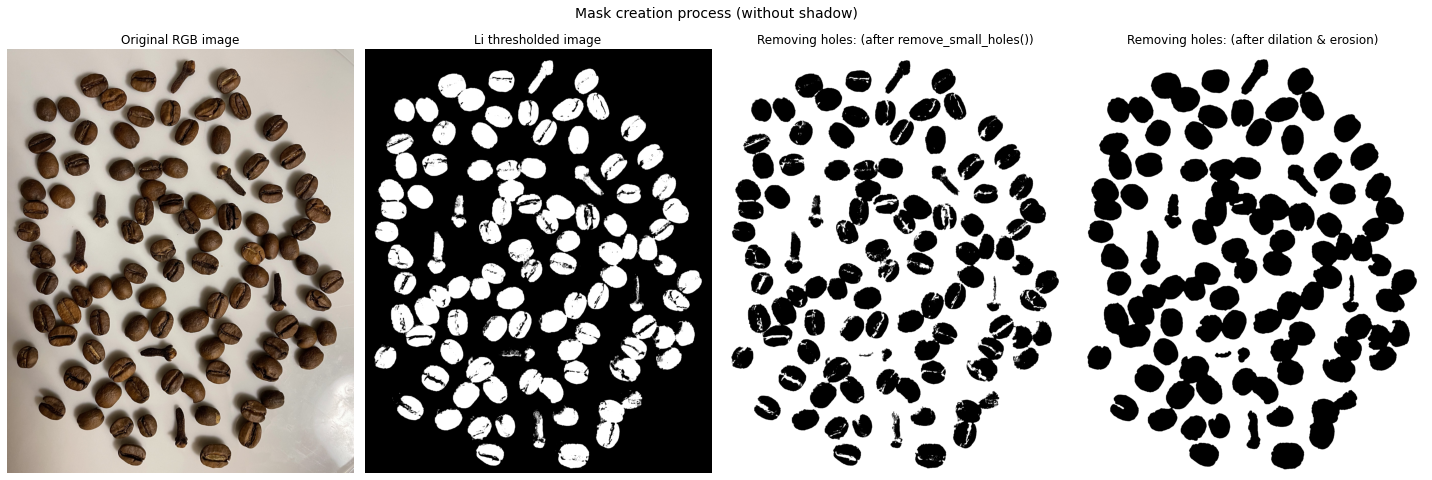

In [ ]:
# Displaying the mask creation process (without shadows)
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 7))
fig.suptitle("Mask creation process (without shadow)", fontsize = 14)

ax[0].imshow(image_RGB)
ax[0].set_title('Original RGB image', fontsize = 12)

ax[1].imshow(binary_li, cmap='gray')
ax[1].set_title("Li thresholded image", fontsize = 12)

ax[2].imshow(holes_filled_without_shadow, cmap='gray')
ax[2].set_title("Removing holes: (after remove_small_holes())", fontsize = 12)

ax[3].imshow(mask_without_shadow, cmap='gray')
ax[3].set_title("Removing holes: (after dilation & erosion)", fontsize = 12)

for row in ax:
    row.axis('off')

fig.tight_layout()
plt.show()

<center>Figure- 7: Mask creation process (without shadow) </center>

**Step 3: Generating the masked image without shadows**: For masking of the image a function named masking_image() has been used which works in the following manner.
  - Converts the  mask from the gray-format to the RGB-format for helping with the merging of images
  - In the mask, the background is white and the objects are black. So, each pixel of mask has been checked. If the value is 255(white), it has been copied to the RGB image. Thus, we are getting our masked image without any shadows.

In [ ]:
# The function masking_image() and display_mask_results() works for both the masks(with shadow & without shadow)
# Function for creating the mask image which takes 2 images as parameters: original RGB image & the mask
def masking_image(image_RGB, mask):
    """ Parameters:
        image_RGB: the original RGB image
        mask: image where objects are black and backgrouns is white
    Return:
        masked_image: Result image where the background of the original RGB image has been replaced with white"""

    RGB_mask = gray2rgb(mask)# Converting the mask from gray to RGB format
    masked_image = image_RGB.copy() # Creating a copy of the RGB image

    shape = np.shape(RGB_mask)
    for i in range(shape[0]):
        for j in range(shape[1]):
            a, b, c = RGB_mask[i, j]
            if (a == 1.0) and (b== 1.0) and (c==1.0): # Checking if the pixel from the mask is white
                masked_image[i, j] = [255, 255, 255] # Setting the pixel of the original image to white
    return masked_image

# Displaying the final masked results
def display_mask_results(image_RGB, mask, masked_answer, masking_type = ""):
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 8))

    ax[0].imshow(image_RGB)
    ax[0].set_title('Original RGB image', fontsize = 14)

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Mask "+ masking_type, fontsize = 14)

    ax[2].imshow(masked_answer, cmap='gray')
    ax[2].set_title("Masked result " + masking_type , fontsize = 14)

    for row in ax:
        row.axis('off')

    fig.tight_layout()
    plt.show()

In [ ]:
# Generating the masked image without shadows
without_shadow_masked_result = masking_image(image_RGB, mask_without_shadow)

# Displaying the masked results without shadows
display_mask_results(image_RGB, mask_without_shadow, without_shadow_masked_result, masking_type = "without shadow")

<center>Figure- 8: Masking process (without shadow) </center>

### Masking with shadow

**Step 1: Mask creation:**
- After analysing all the thresholding methods, chosen Otsu for binarising the image.
- After binarisation, on the inverted binary image performed fill holes using remove_small_holes() with area_threshold = 8000.
- Then inverted the image for obtainng the final mask.

In [ ]:
# Binarising the image using the Otsu filter
thresh_with_shadow = threshold_otsu(image_gray)
binary_otsu_with_shadow = image_gray > thresh_with_shadow

# Filling the holes of the objects in the binary image
inverted_binary_otsu = np.invert(binary_otsu_with_shadow)
holes_filled_with_shadow = remove_small_holes(inverted_binary_otsu, area_threshold = 8000)

# Creating the mask with shadows
mask_with_shadow = np.invert(holes_filled_with_shadow)*1.0

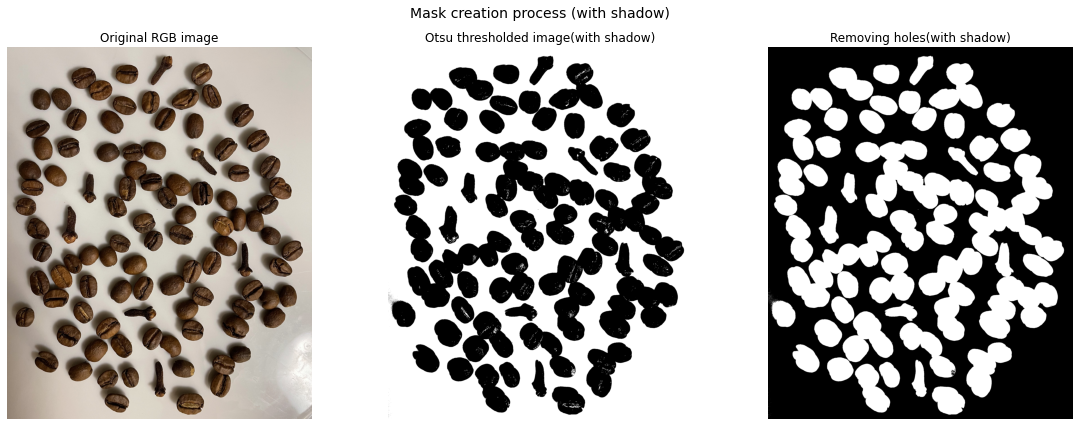

In [ ]:
# Displaying the images
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 6))
fig.suptitle("Mask creation process (with shadow)", fontsize = 14)

ax[0].imshow(image_RGB)
ax[0].set_title('Original RGB image', fontsize = 12)

ax[1].imshow(binary_otsu_with_shadow, cmap='gray')
ax[1].set_title("Otsu thresholded image(with shadow)", fontsize = 12)

ax[2].imshow(holes_filled_with_shadow, cmap='gray')
ax[2].set_title("Removing holes(with shadow)", fontsize = 12)


for row in ax:
    row.axis('off')

fig.tight_layout()
plt.show()

<center>Figure- 9: Mask creation process (with shadow)</center>

**Step 2: Generating the masked image with shadows:** Using the same function masking_image() as before the masking is performed. Here, the original RGB image and the mask_with_shadow has been used.

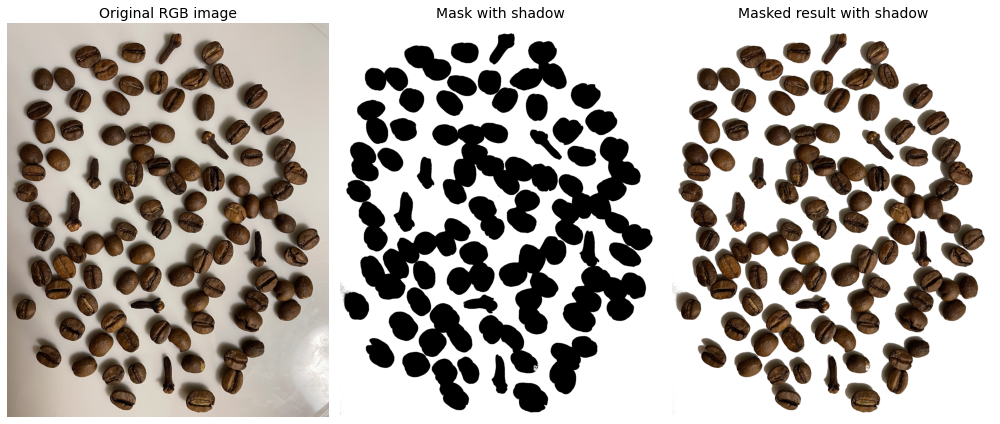

In [ ]:
# Generating the masked image with shadows
shadow_masked_result = masking_image(image_RGB, mask_with_shadow)

#Displaying the masked results with shadow
display_mask_results(image_RGB, mask_with_shadow,shadow_masked_result, masking_type = "with shadow")

<center>Figure- 10: Masking process (with shadow)</center>

### Comparison of the masked image with and without shadow

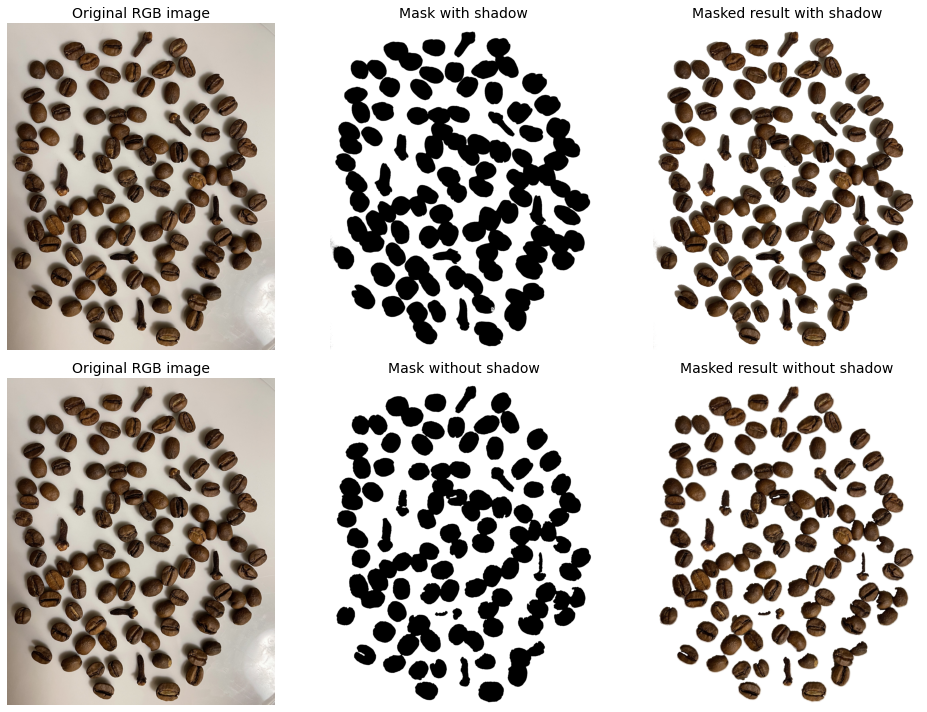

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (14, 10))

ax[0, 0].imshow(image_RGB)
ax[0, 0].set_title('Original RGB image', fontsize = 14)

ax[0, 1].imshow(mask_with_shadow, cmap='gray')
ax[0, 1].set_title("Mask with shadow", fontsize = 14)

ax[0, 2].imshow(shadow_masked_result, cmap='gray')
ax[0, 2].set_title("Masked result with shadow" , fontsize = 14)

ax[1, 0].imshow(image_RGB)
ax[1, 0].set_title('Original RGB image', fontsize = 14)

ax[1, 1].imshow(mask_without_shadow, cmap='gray')
ax[1, 1].set_title("Mask without shadow", fontsize = 14)

ax[1, 2].imshow(without_shadow_masked_result, cmap='gray')
ax[1, 2].set_title("Masked result without shadow" , fontsize = 14)

for row in ax:
    for col in row:
        col.axis('off')

fig.tight_layout()
plt.show()

<center>Figure- 11: Comparison of the masked image with and without shadow</center>

#### Comments on the comparison
From the Figure-11, I have identified the followings.
- In both of the images, the backgrounds have been successfully removed.
- The masked image with the shadows has all the objects intact, even though the shadows are present.
- The masked image without the shadows has a few parts of some of the objects missing.

Hence, depending on our need, we can choose any of the procedures for masking.

<a id='E2c'></a>
## <font color='blue '>Exercise 2 (c): Counting the coffee beans<font>

For counting the coffee beans, I have used the below mentioned 5 steps:
- **Step 1: Getting the mask**: For counting the beans, I am using the mask that I had created for Exercise 2 (b). I will be using the mask with the shadows.
- **Step 2: Distance map**: Generated a "Distance map" for understanding the distance between the objects.
- **Step 3: Watershed for object detection**: Using the "distance map", the "watershed" process has been applied on the image for separating the merged objects. Here, after experimenting with different min_distances, I have chosen 90 as the optimal value. It ensures that local peaks are not too close. Thus, helps in the separation of the very closely placed beans.
- **Step 4: Measure the objects**: For getting the properties of the detected objects, I have used the measure module from the skimage.
- **Step 5: Detecting the beans**: For identifying the beans, 3 properties has been used.
    - Eccentricity:  It has value in the interval (0, 1). When it is 0, the ellipse becomes a circle. Since the beans are more rounder than the cloves, I have set it to less than 0.901.
    - Area: Set it to greater than 25000.
    - Major_axis_length: Set it to greater than 100.
- **Step 6: Marking the beans**: For better visualisation, I have marked the beans with numbers in the image using the text from the matplotlib.
    
**Using the above mentioned process, I have idnetified, there are 93 beans present in the image**. The code has been presented below.


In [ ]:
# Step2: Generating the Distance map
distance = ndi.distance_transform_edt(holes_filled_with_shadow)

# Step3: Using the watershed for separating the merged objects
local_maxi = peak_local_max(distance, min_distance = 90, indices = False, footprint = np.ones((26,26)),
                            labels = holes_filled_with_shadow.astype(int))
markers = ndi.label(local_maxi)[0]
labels_objects_detected = watershed(-distance, markers, mask = holes_filled_with_shadow, watershed_line = True)

# Step4: Measuring the properties of the objects detected
labels2 = measure.label(labels_objects_detected)
properties = measure.regionprops(labels2)

# Step5: Detecting the beans
truncated_beans = [prop for prop in properties if (prop.eccentricity<=0.901 and prop.area>=25000
                                                   and prop.major_axis_length >= 100)]

print("Number of beans:", len(truncated_beans))
image_beans = holes_filled_with_shadow[:,:]*1

for obj in truncated_beans:
    for coord in obj.coords:
        image_beans[coord[0], coord[1]] = 2

Number of beans: 93


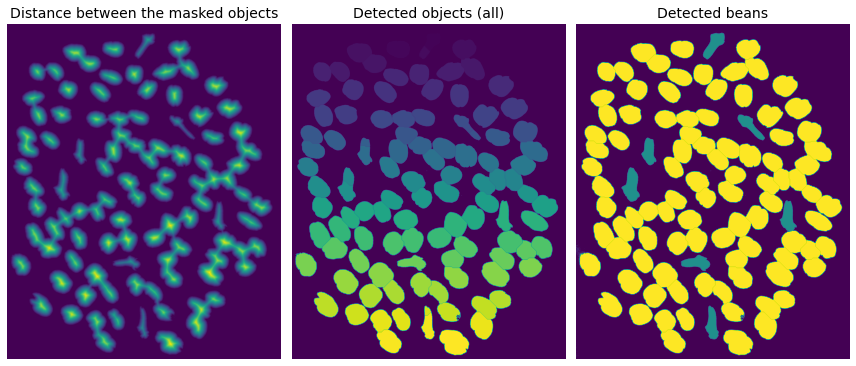

In [ ]:
# Displaying the watershed results and beans detected
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 6))
ax[0].imshow(distance)
ax[0].set_title('Distance between the masked objects', fontsize = 14)

ax[1].imshow(labels_objects_detected)
ax[1].set_title("Detected objects (all)", fontsize = 14)

ax[2].imshow(image_beans)
ax[2].set_title("Detected beans", fontsize = 14)

for row in ax:
    row.axis('off')
fig.tight_layout()
plt.show()

<center>Figure- 12: Bean counting process</center>

#### Step 6: Marking the detected beans with numbers
Detected beans have been marked with white text using the information in the centroids.

In [ ]:
# Finding the center points for putting the number/text on the beans
centers =[]
for prop in truncated_beans:
    y, x = prop.centroid # unpacking the centroids for minimizing the decimal points
    centers.append((round(x, 2), round(y, 2)))

# Adding numbers on the beans
plt.subplots(1,1,figsize=(14, 10))
number = 1
for center in centers:
    plt.gca().text(x = center[0], y = center[1], s= "  "+str(number), horizontalalignment='center', fontsize = 12,
                   verticalalignment='center', fontweight='extra bold', color='white')
    number+=1

# Displaying the detected beans
plt.imshow(image_RGB , cmap='gray')
plt.title(label = "Beans detected", fontsize=14)
plt.axis('off')
plt.show()

<center>Figure- 13: Marked & counted beans</center>

<a id='E2d'></a>
## <font color='blue '>Exercise 2 (d): List with the center x, y positions of all the coffee beans<font>

We know from the geometry, the center x, y positions of an object is called an "centroid" or "geometric center". In the properties of the "measure" module of the skimage, there is an attribute called "centroid". This attribute has the center of the detected object stored as an coordinate tuple (Y, X) or (row, col). Utilizing this attribute, I have created a list of the centroid locations for all the detected beans where the centers are represented in the tuple format (X, Y). While storing the positions/centers, I have chosen to take only 2 decimal points for better represendation of the results.

In [ ]:
# Listing the center of the detected beans
bean_locations =[]
for prop in truncated_beans:
    y, x = prop.centroid # unpacking the centroids for minimizing the decimal points
    bean_locations.append((round(x, 2), round(y, 2)))
print("Number of detected beans:", len(bean_locations))
print("Centroid of the detected beans:", bean_locations)

Number of detected beans: 93
Centroid of the detected beans: [(1715.44, 247.33), (1060.48, 248.95), (669.31, 280.11), (827.22, 394.99), (1806.83, 444.7), (480.45, 470.5), (302.03, 476.29), (1582.3, 475.62), (1268.59, 500.07), (1035.47, 527.96), (2080.37, 614.58), (1401.08, 651.19), (609.0, 652.76), (930.05, 676.04), (1668.27, 712.01), (261.31, 735.89), (2214.03, 837.89), (1925.48, 912.24), (315.49, 913.74), (540.28, 900.67), (1313.16, 929.86), (893.64, 947.83), (1112.74, 945.09), (2322.82, 1071.86), (194.89, 1101.99), (1136.11, 1102.7), (2049.74, 1128.62), (428.3, 1156.53), (1279.3, 1211.22), (1519.61, 1236.37), (1058.47, 1268.13), (210.14, 1254.8), (2412.61, 1266.84), (1731.88, 1311.77), (1417.41, 1353.27), (1956.39, 1374.76), (2304.41, 1409.0), (970.16, 1429.56), (158.43, 1425.61), (1585.84, 1505.4), (2054.77, 1545.83), (2205.97, 1555.22), (1206.35, 1567.4), (1908.44, 1594.09), (265.04, 1628.69), (1536.34, 1674.66), (2348.11, 1693.6), (1298.22, 1733.51), (992.12, 1753.14), (1942.68, 

<a id='E2e'></a>
## <font color='blue '>Exercise 2 (e): Computing the size of the coffee beans is challenging <font>

**Area detection with the shadows:** Similar to the *Exercise 2(d)*, we can obtain the area or the size of the detected objects from the properties of the "measure" module of the skimage. But the areas of the beans are not 100% accurate. Because when the objects were being detected, their shadows were not taken into the consideration which is now included in the area of the each detected object. So, not a good way of computing the area.
    
**Area detection without the shadows:** Detecting the areas without the shadows is also quite challenging. Because for measuring the objects, we first need to detect the objects. From *Exercise 2(b)*, we can see during the shadow removal process using the mask, a few of beans had newly developed holes and cracks in them which is not suitable for the watershedding to work properly. Hence, it is quite challening to detect the areas.


In [ ]:
# Computing the size/area of the detected beans with shadows [Not accurate]
bean_areas =[]
for prop in truncated_beans:
    bean_areas.append(prop.area)

print("Bean sizes:", bean_areas)

Bean sizes: [36948, 33149, 36158, 33727, 37150, 28690, 27468, 37993, 33704, 32735, 41129, 34623, 33211, 34199, 34907, 30297, 42708, 41577, 31738, 33820, 29834, 31044, 29307, 40938, 29947, 28856, 32355, 30867, 29429, 35650, 36462, 30426, 41376, 41268, 30208, 28721, 35700, 30906, 29616, 30091, 27160, 29697, 35768, 30892, 34946, 38313, 25413, 29273, 30399, 35048, 40771, 32712, 27188, 28813, 39154, 27492, 36998, 36812, 41576, 38348, 37908, 35388, 39786, 37539, 40297, 36420, 36374, 33958, 40134, 26507, 36374, 35055, 31605, 38309, 34206, 48981, 45258, 39544, 44857, 36664, 33229, 30083, 41395, 29769, 41586, 38814, 32107, 38874, 29794, 35127, 43543, 40279, 55090]
